# DiD Analysis Visualizations

This notebook visualizes the Difference-in-Differences (DiD) analysis for four hypotheses regarding opioid policy interventions in Florida (2010) and Washington (2012). Each section below corresponds to one hypothesis and includes a plot of the fitted pre- and post-policy trendlines for the treated and control groups, with a break at the policy year.

**Control Groups:**
- Florida: North Carolina (NC), South Carolina (SC), Georgia (GA), Tennessee (TN), Mississippi (MS)
- Washington: Montana (MT), Oregon (OR), Idaho (ID), Colorado (CO), California (CA)

Axis labels and variable names match those used in the parallel trends notebook for consistency.

## 1. Import Required Libraries
Import pandas, numpy, matplotlib, seaborn, and set pandas options for analysis.

In [1]:
# Imports and display settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("mode.copy_on_write", True)

## 2. Load Data
Load the cleaned and merged dataset used for DiD analysis.

In [2]:
# Load the final merged dataset (150K threshold, end-use buyers)
df = pd.read_csv("../01_data/clean/final_merged_150k.csv")
print(f"Loaded {len(df)} observations")

Loaded 566 observations


## 3. H1-FL: Florida Policy Effect on Opioid Volume
Visualize the effect of Florida's 2010 policy on opioid volume per capita (MME per capita), using fitted pre- and post-policy trendlines for Florida and its control states.

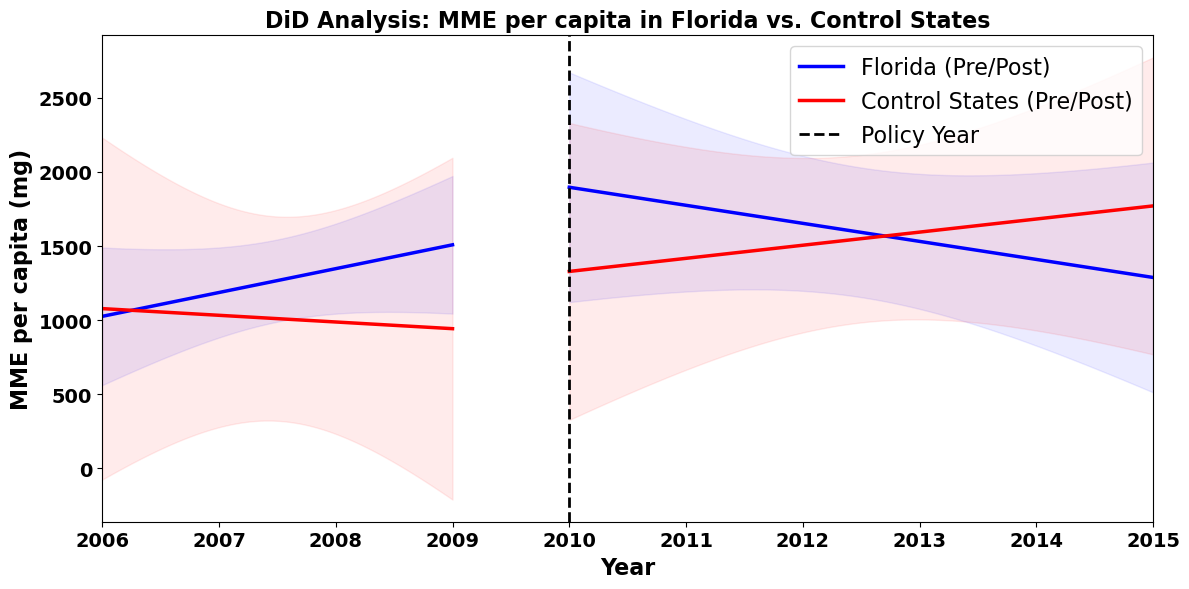

In [3]:
# Prepare and plot DiD analysis for Florida opioid volume
states_fl = [
    "Florida",
    "North Carolina",
    "South Carolina",
    "Georgia",
    "Tennessee",
    "Mississippi",
]
fl_did = df[
    (df["STNAME"].isin(states_fl)) & (df["Year"] >= 2006) & (df["Year"] <= 2015)
].copy()
fl_did["treated"] = (fl_did["STNAME"] == "Florida").astype(int)
fl_did["post"] = (fl_did["Year"] > 2010).astype(int)

# Aggregate to state-year level
fl_did_agg = fl_did.groupby(["STNAME", "Year", "treated", "post"], as_index=False).agg(
    {"TOTAL_MME": "mean", "population": "mean"}
)
fl_did_agg["MME per capita"] = fl_did_agg["TOTAL_MME"] / fl_did_agg["population"]

# Prepare data for trendlines
fl_treated = fl_did_agg[fl_did_agg["treated"] == 1]
fl_control = (
    fl_did_agg[fl_did_agg["treated"] == 0]
    .groupby("Year", as_index=False)["MME per capita"]
    .mean()
)

# Fit pre-period trendlines (2006-2009)
pre_treated = fl_treated[fl_treated["Year"] < 2010]
pre_control = fl_control[fl_control["Year"] < 2010]
z_treated_pre = np.polyfit(pre_treated["Year"], pre_treated["MME per capita"], 1)
p_treated_pre = np.poly1d(z_treated_pre)
z_control_pre = np.polyfit(pre_control["Year"], pre_control["MME per capita"], 1)
p_control_pre = np.poly1d(z_control_pre)

# Fit post-period trendlines (2010-2015)
post_treated = fl_treated[fl_treated["Year"] >= 2010]
post_control = fl_control[fl_control["Year"] >= 2010]
z_treated_post = np.polyfit(post_treated["Year"], post_treated["MME per capita"], 1)
p_treated_post = np.poly1d(z_treated_post)
z_control_post = np.polyfit(post_control["Year"], post_control["MME per capita"], 1)
p_control_post = np.poly1d(z_control_post)

import scipy.stats as stats


# Confidence band function for trendlines
def polyfit_confidence_band(x, y, degree, x_pred, alpha=0.05):
    p, cov = np.polyfit(x, y, degree, cov=True)
    y_pred = np.polyval(p, x_pred)
    n = len(x)
    y_fit = np.polyval(p, x)
    residuals = y - y_fit
    s_err = np.sqrt(np.sum(residuals**2) / (n - degree - 1))
    t_val = stats.t.ppf(1 - alpha / 2, n - degree - 1)
    mean_x = np.mean(x)
    conf = (
        t_val
        * s_err
        * np.sqrt(1 / n + (x_pred - mean_x) ** 2 / np.sum((x - mean_x) ** 2))
    )
    return y_pred, conf


# Plot fitted lines for pre and post periods with confidence bands
fig, ax = plt.subplots(figsize=(12, 6))
years_pre = np.linspace(2006, 2009, 100)
years_post = np.linspace(2010, 2015, 100)

# Pre-period: Treated
y_pre_treated, conf_pre_treated = polyfit_confidence_band(
    pre_treated["Year"], pre_treated["MME per capita"], 1, years_pre, alpha=0.01
)
ax.plot(
    years_pre,
    y_pre_treated,
    "-",
    color="blue",
    linewidth=2.5,
    label="Florida (Pre/Post)",
)
ax.fill_between(
    years_pre,
    y_pre_treated - conf_pre_treated,
    y_pre_treated + conf_pre_treated,
    color="blue",
    alpha=0.08,
)

# Pre-period: Control
y_pre_control, conf_pre_control = polyfit_confidence_band(
    pre_control["Year"], pre_control["MME per capita"], 1, years_pre, alpha=0.01
)
ax.plot(
    years_pre,
    y_pre_control,
    "-",
    color="red",
    linewidth=2.5,
    label="Control States (Pre/Post)",
)
ax.fill_between(
    years_pre,
    y_pre_control - conf_pre_control,
    y_pre_control + conf_pre_control,
    color="red",
    alpha=0.08,
)

# Post-period: Treated
y_post_treated, conf_post_treated = polyfit_confidence_band(
    post_treated["Year"], post_treated["MME per capita"], 1, years_post, alpha=0.01
)
ax.plot(years_post, y_post_treated, "-", color="blue", linewidth=2.5)
ax.fill_between(
    years_post,
    y_post_treated - conf_post_treated,
    y_post_treated + conf_post_treated,
    color="blue",
    alpha=0.08,
)

# Post-period: Control
y_post_control, conf_post_control = polyfit_confidence_band(
    post_control["Year"], post_control["MME per capita"], 1, years_post, alpha=0.01
)
ax.plot(years_post, y_post_control, "-", color="red", linewidth=2.5)
ax.fill_between(
    years_post,
    y_post_control - conf_post_control,
    y_post_control + conf_post_control,
    color="red",
    alpha=0.08,
)

ax.axvline(x=2010, color="black", linestyle="--", linewidth=2, label="Policy Year")
ax.set_xlabel("Year", fontsize=16, fontweight="bold")
ax.set_ylabel("MME per capita (mg)", fontsize=16, fontweight="bold")
ax.set_title(
    "DiD Analysis: MME per capita in Florida vs. Control States",
    fontsize=16,
    fontweight="bold",
)
ax.legend(loc="upper right", fontsize=16)
ax.set_xlim(2006, 2015)
ax.tick_params(axis="both", labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")
plt.tight_layout()

import os

output_dir = os.path.join("..", "05_outputs", "figures")
fig_filename = os.path.join(output_dir, "did_FL_MME_per_capita.png")
plt.savefig(fig_filename, dpi=300, bbox_inches="tight")
plt.show()

## 4. H2-FL: Florida Policy Effect on Overdose Mortality
Visualize the effect of Florida's 2010 policy on overdose mortality rate, using fitted pre- and post-policy trendlines for Florida and its control states.

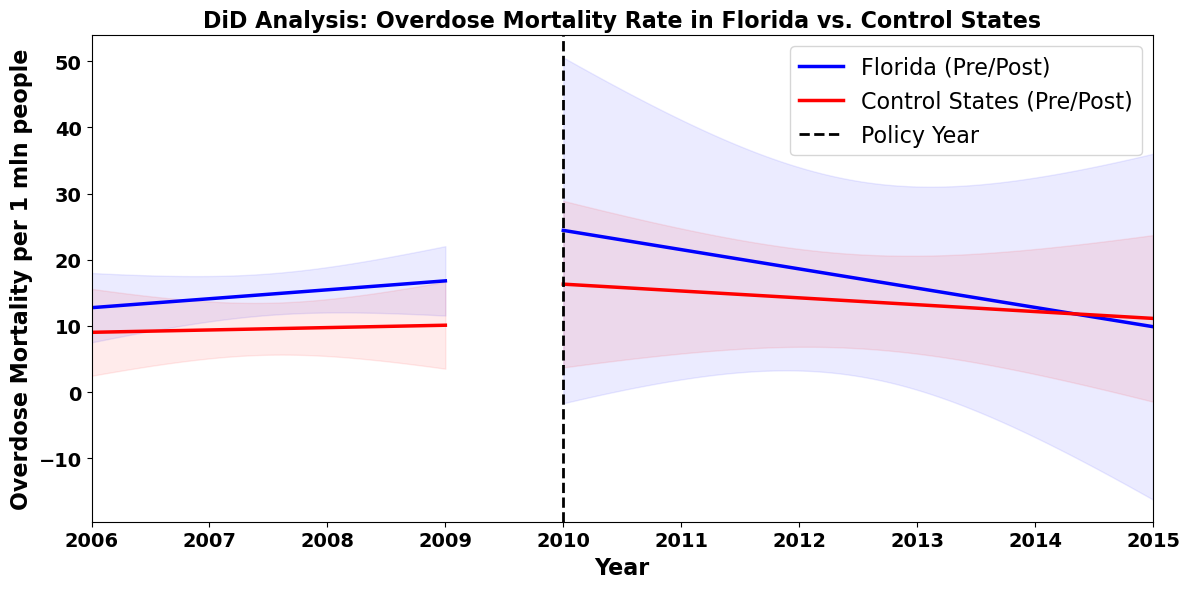

In [4]:
# Prepare and plot DiD analysis for Florida overdose mortality
fl_did_agg2 = fl_did.groupby(["STNAME", "Year", "treated", "post"], as_index=False).agg(
    {"Deaths": "mean", "population": "mean"}
)
fl_did_agg2["Overdose Deaths per capita"] = (
    fl_did_agg2["Deaths"] / fl_did_agg2["population"] * 100000
)

fl_treated2 = fl_did_agg2[fl_did_agg2["treated"] == 1]
fl_control2 = (
    fl_did_agg2[fl_did_agg2["treated"] == 0]
    .groupby("Year", as_index=False)["Overdose Deaths per capita"]
    .mean()
)

# Fit pre-period trendlines (2006-2009)
pre_treated2 = fl_treated2[fl_treated2["Year"] < 2010]
pre_control2 = fl_control2[fl_control2["Year"] < 2010]
z_treated_pre2 = np.polyfit(
    pre_treated2["Year"], pre_treated2["Overdose Deaths per capita"], 1
)
p_treated_pre2 = np.poly1d(z_treated_pre2)
z_control_pre2 = np.polyfit(
    pre_control2["Year"], pre_control2["Overdose Deaths per capita"], 1
)
p_control_pre2 = np.poly1d(z_control_pre2)

# Fit post-period trendlines (2010-2015)
post_treated2 = fl_treated2[fl_treated2["Year"] >= 2010]
post_control2 = fl_control2[fl_control2["Year"] >= 2010]
z_treated_post2 = np.polyfit(
    post_treated2["Year"], post_treated2["Overdose Deaths per capita"], 1
)
p_treated_post2 = np.poly1d(z_treated_post2)
z_control_post2 = np.polyfit(
    post_control2["Year"], post_control2["Overdose Deaths per capita"], 1
)
p_control_post2 = np.poly1d(z_control_post2)


# Confidence band function for trendlines
def polyfit_confidence_band(x, y, degree, x_pred, alpha=0.05):
    p, cov = np.polyfit(x, y, degree, cov=True)
    y_pred = np.polyval(p, x_pred)
    n = len(x)
    y_fit = np.polyval(p, x)
    residuals = y - y_fit
    s_err = np.sqrt(np.sum(residuals**2) / (n - degree - 1))
    t_val = stats.t.ppf(1 - alpha / 2, n - degree - 1)
    mean_x = np.mean(x)
    conf = (
        t_val
        * s_err
        * np.sqrt(1 / n + (x_pred - mean_x) ** 2 / np.sum((x - mean_x) ** 2))
    )
    return y_pred, conf


# Plot fitted lines for pre and post periods with confidence bands
fig, ax = plt.subplots(figsize=(12, 6))
years_pre2 = np.linspace(2006, 2009, 100)
years_post2 = np.linspace(2010, 2015, 100)

# Pre-period: Treated
y_pre_treated2, conf_pre_treated2 = polyfit_confidence_band(
    pre_treated2["Year"],
    pre_treated2["Overdose Deaths per capita"],
    1,
    years_pre2,
    alpha=0.01,
)
ax.plot(
    years_pre2,
    y_pre_treated2,
    "-",
    color="blue",
    linewidth=2.5,
    label="Florida (Pre/Post)",
)
ax.fill_between(
    years_pre2,
    y_pre_treated2 - conf_pre_treated2,
    y_pre_treated2 + conf_pre_treated2,
    color="blue",
    alpha=0.08,
)

# Pre-period: Control
y_pre_control2, conf_pre_control2 = polyfit_confidence_band(
    pre_control2["Year"],
    pre_control2["Overdose Deaths per capita"],
    1,
    years_pre2,
    alpha=0.01,
)
ax.plot(
    years_pre2,
    y_pre_control2,
    "-",
    color="red",
    linewidth=2.5,
    label="Control States (Pre/Post)",
)
ax.fill_between(
    years_pre2,
    y_pre_control2 - conf_pre_control2,
    y_pre_control2 + conf_pre_control2,
    color="red",
    alpha=0.08,
)

# Post-period: Treated
y_post_treated2, conf_post_treated2 = polyfit_confidence_band(
    post_treated2["Year"],
    post_treated2["Overdose Deaths per capita"],
    1,
    years_post2,
    alpha=0.01,
)
ax.plot(years_post2, y_post_treated2, "-", color="blue", linewidth=2.5)
ax.fill_between(
    years_post2,
    y_post_treated2 - conf_post_treated2,
    y_post_treated2 + conf_post_treated2,
    color="blue",
    alpha=0.08,
)

# Post-period: Control
y_post_control2, conf_post_control2 = polyfit_confidence_band(
    post_control2["Year"],
    post_control2["Overdose Deaths per capita"],
    1,
    years_post2,
    alpha=0.01,
)
ax.plot(years_post2, y_post_control2, "-", color="red", linewidth=2.5)
ax.fill_between(
    years_post2,
    y_post_control2 - conf_post_control2,
    y_post_control2 + conf_post_control2,
    color="red",
    alpha=0.08,
)

ax.axvline(x=2010, color="black", linestyle="--", linewidth=2, label="Policy Year")
ax.set_xlabel("Year", fontsize=16, fontweight="bold")
ax.set_ylabel("Overdose Mortality per 1 mln people", fontsize=16, fontweight="bold")
ax.set_title(
    "DiD Analysis: Overdose Mortality Rate in Florida vs. Control States",
    fontsize=16,
    fontweight="bold",
)
ax.legend(loc="upper right", fontsize=16)
ax.set_xlim(2006, 2015)
ax.tick_params(axis="both", labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")
plt.tight_layout()

import os

output_dir = os.path.join("..", "05_outputs", "figures")
os.makedirs(output_dir, exist_ok=True)
fig_filename = os.path.join(output_dir, "did_FL_overdose_mortality.png")
plt.savefig(fig_filename, dpi=300, bbox_inches="tight")
plt.show()

## 5. H1-WA: Washington Policy Effect on Opioid Volume
Visualize the effect of Washington's 2012 policy on opioid volume per capita (MME per capita), using fitted pre- and post-policy trendlines for Washington and its control states.

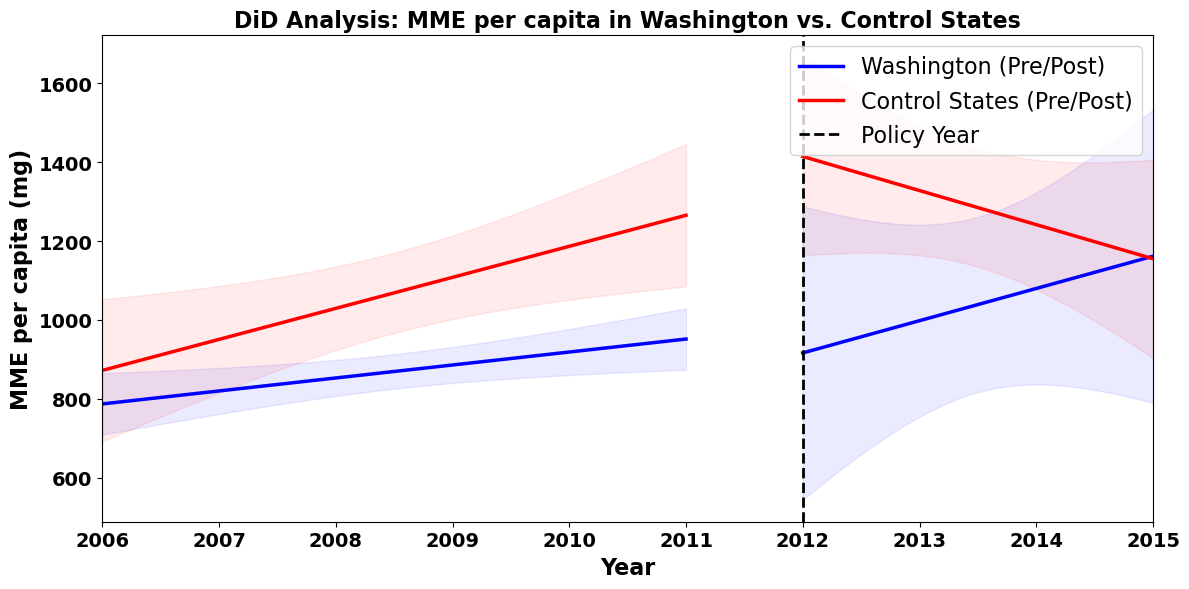

In [5]:
# Prepare and plot DiD analysis for Washington opioid volume
states_wa = ["Washington", "Montana", "Oregon", "Idaho", "Colorado", "California"]
wa_did = df[
    (df["STNAME"].isin(states_wa)) & (df["Year"] >= 2006) & (df["Year"] <= 2015)
].copy()
wa_did["treated"] = (wa_did["STNAME"] == "Washington").astype(int)
wa_did["post"] = (wa_did["Year"] > 2012).astype(int)

# Aggregate to state-year level
wa_did_agg = wa_did.groupby(["STNAME", "Year", "treated", "post"], as_index=False).agg(
    {"TOTAL_MME": "mean", "population": "mean"}
)
wa_did_agg["MME per capita"] = wa_did_agg["TOTAL_MME"] / wa_did_agg["population"]

# Prepare data for trendlines
wa_treated = wa_did_agg[wa_did_agg["treated"] == 1]
wa_control = (
    wa_did_agg[wa_did_agg["treated"] == 0]
    .groupby("Year", as_index=False)["MME per capita"]
    .mean()
)

# Fit pre-period trendlines (2006-2011)
pre_treated_wa = wa_treated[wa_treated["Year"] < 2012]
pre_control_wa = wa_control[wa_control["Year"] < 2012]
z_treated_pre_wa = np.polyfit(
    pre_treated_wa["Year"], pre_treated_wa["MME per capita"], 1
)
p_treated_pre_wa = np.poly1d(z_treated_pre_wa)
z_control_pre_wa = np.polyfit(
    pre_control_wa["Year"], pre_control_wa["MME per capita"], 1
)
p_control_pre_wa = np.poly1d(z_control_pre_wa)

# Fit post-period trendlines (2012-2015)
post_treated_wa = wa_treated[wa_treated["Year"] >= 2012]
post_control_wa = wa_control[wa_control["Year"] >= 2012]
z_treated_post_wa = np.polyfit(
    post_treated_wa["Year"], post_treated_wa["MME per capita"], 1
)
p_treated_post_wa = np.poly1d(z_treated_post_wa)
z_control_post_wa = np.polyfit(
    post_control_wa["Year"], post_control_wa["MME per capita"], 1
)
p_control_post_wa = np.poly1d(z_control_post_wa)


# Confidence band function for trendlines
def polyfit_confidence_band(x, y, degree, x_pred, alpha=0.05):
    p, cov = np.polyfit(x, y, degree, cov=True)
    y_pred = np.polyval(p, x_pred)
    n = len(x)
    y_fit = np.polyval(p, x)
    residuals = y - y_fit
    s_err = np.sqrt(np.sum(residuals**2) / (n - degree - 1))
    t_val = stats.t.ppf(1 - alpha / 2, n - degree - 1)
    mean_x = np.mean(x)
    conf = (
        t_val
        * s_err
        * np.sqrt(1 / n + (x_pred - mean_x) ** 2 / np.sum((x - mean_x) ** 2))
    )
    return y_pred, conf


# Plot fitted lines for pre and post periods with confidence bands
fig, ax = plt.subplots(figsize=(12, 6))
years_pre_wa = np.linspace(2006, 2011, 100)
years_post_wa = np.linspace(2012, 2015, 100)

# Pre-period: Treated
y_pre_treated_wa, conf_pre_treated_wa = polyfit_confidence_band(
    pre_treated_wa["Year"],
    pre_treated_wa["MME per capita"],
    1,
    years_pre_wa,
    alpha=0.01,
)
ax.plot(
    years_pre_wa,
    y_pre_treated_wa,
    "-",
    color="blue",
    linewidth=2.5,
    label="Washington (Pre/Post)",
)
ax.fill_between(
    years_pre_wa,
    y_pre_treated_wa - conf_pre_treated_wa,
    y_pre_treated_wa + conf_pre_treated_wa,
    color="blue",
    alpha=0.08,
)

# Pre-period: Control
y_pre_control_wa, conf_pre_control_wa = polyfit_confidence_band(
    pre_control_wa["Year"],
    pre_control_wa["MME per capita"],
    1,
    years_pre_wa,
    alpha=0.01,
)
ax.plot(
    years_pre_wa,
    y_pre_control_wa,
    "-",
    color="red",
    linewidth=2.5,
    label="Control States (Pre/Post)",
)
ax.fill_between(
    years_pre_wa,
    y_pre_control_wa - conf_pre_control_wa,
    y_pre_control_wa + conf_pre_control_wa,
    color="red",
    alpha=0.08,
)

# Post-period: Treated
y_post_treated_wa, conf_post_treated_wa = polyfit_confidence_band(
    post_treated_wa["Year"],
    post_treated_wa["MME per capita"],
    1,
    years_post_wa,
    alpha=0.01,
)
ax.plot(years_post_wa, y_post_treated_wa, "-", color="blue", linewidth=2.5)
ax.fill_between(
    years_post_wa,
    y_post_treated_wa - conf_post_treated_wa,
    y_post_treated_wa + conf_post_treated_wa,
    color="blue",
    alpha=0.08,
)

# Post-period: Control
y_post_control_wa, conf_post_control_wa = polyfit_confidence_band(
    post_control_wa["Year"],
    post_control_wa["MME per capita"],
    1,
    years_post_wa,
    alpha=0.01,
)
ax.plot(years_post_wa, y_post_control_wa, "-", color="red", linewidth=2.5)
ax.fill_between(
    years_post_wa,
    y_post_control_wa - conf_post_control_wa,
    y_post_control_wa + conf_post_control_wa,
    color="red",
    alpha=0.08,
)

ax.axvline(x=2012, color="black", linestyle="--", linewidth=2, label="Policy Year")
ax.set_xlabel("Year", fontsize=16, fontweight="bold")
ax.set_ylabel("MME per capita (mg)", fontsize=16, fontweight="bold")
ax.set_title(
    "DiD Analysis: MME per capita in Washington vs. Control States",
    fontsize=16,
    fontweight="bold",
)
ax.legend(loc="upper right", fontsize=16)
ax.set_xlim(2006, 2015)
ax.tick_params(axis="both", labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")
plt.tight_layout()

output_dir = os.path.join("..", "05_outputs", "figures")
os.makedirs(output_dir, exist_ok=True)
fig_filename = os.path.join(output_dir, "did_WA_MME_per_capita.png")
plt.savefig(fig_filename, dpi=300, bbox_inches="tight")
plt.show()

## 6. H2-WA: Washington Policy Effect on Overdose Mortality
Visualize the effect of Washington's 2012 policy on overdose mortality rate, using fitted pre- and post-policy trendlines for Washington and its control states.

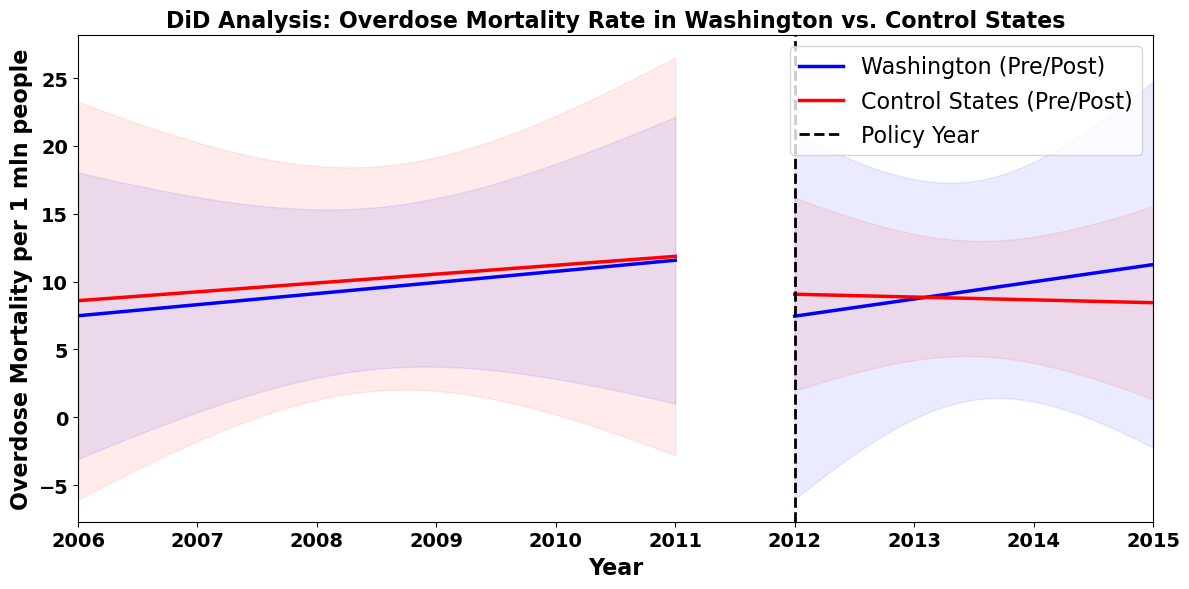

In [6]:
# Prepare and plot DiD analysis for Washington overdose mortality
wa_did_agg2 = wa_did.groupby(["STNAME", "Year", "treated", "post"], as_index=False).agg(
    {"Deaths": "mean", "population": "mean"}
)
wa_did_agg2["Overdose Deaths per capita"] = (
    wa_did_agg2["Deaths"] / wa_did_agg2["population"] * 100000
)

wa_treated2 = wa_did_agg2[wa_did_agg2["treated"] == 1]
wa_control2 = (
    wa_did_agg2[wa_did_agg2["treated"] == 0]
    .groupby("Year", as_index=False)["Overdose Deaths per capita"]
    .mean()
)

# Fit pre-period trendlines (2006-2011)
pre_treated2_wa = wa_treated2[wa_treated2["Year"] < 2012]
pre_control2_wa = wa_control2[wa_control2["Year"] < 2012]
z_treated_pre2_wa = np.polyfit(
    pre_treated2_wa["Year"], pre_treated2_wa["Overdose Deaths per capita"], 1
)
p_treated_pre2_wa = np.poly1d(z_treated_pre2_wa)
z_control_pre2_wa = np.polyfit(
    pre_control2_wa["Year"], pre_control2_wa["Overdose Deaths per capita"], 1
)
p_control_pre2_wa = np.poly1d(z_control_pre2_wa)

# Fit post-period trendlines (2012-2015)
post_treated2_wa = wa_treated2[wa_treated2["Year"] >= 2012]
post_control2_wa = wa_control2[wa_control2["Year"] >= 2012]
z_treated_post2_wa = np.polyfit(
    post_treated2_wa["Year"], post_treated2_wa["Overdose Deaths per capita"], 1
)
p_treated_post2_wa = np.poly1d(z_treated_post2_wa)
z_control_post2_wa = np.polyfit(
    post_control2_wa["Year"], post_control2_wa["Overdose Deaths per capita"], 1
)
p_control_post2_wa = np.poly1d(z_control_post2_wa)


# Confidence band function for trendlines
def polyfit_confidence_band(x, y, degree, x_pred, alpha=0.05):
    p, cov = np.polyfit(x, y, degree, cov=True)
    y_pred = np.polyval(p, x_pred)
    n = len(x)
    y_fit = np.polyval(p, x)
    residuals = y - y_fit
    s_err = np.sqrt(np.sum(residuals**2) / (n - degree - 1))
    t_val = stats.t.ppf(1 - alpha / 2, n - degree - 1)
    mean_x = np.mean(x)
    conf = (
        t_val
        * s_err
        * np.sqrt(1 / n + (x_pred - mean_x) ** 2 / np.sum((x - mean_x) ** 2))
    )
    return y_pred, conf


# Plot fitted lines for pre and post periods with confidence bands
fig, ax = plt.subplots(figsize=(12, 6))
years_pre2_wa = np.linspace(2006, 2011, 100)
years_post2_wa = np.linspace(2012, 2015, 100)

# Pre-period: Treated
y_pre_treated2_wa, conf_pre_treated2_wa = polyfit_confidence_band(
    pre_treated2_wa["Year"],
    pre_treated2_wa["Overdose Deaths per capita"],
    1,
    years_pre2_wa,
    alpha=0.01,
)
ax.plot(
    years_pre2_wa,
    y_pre_treated2_wa,
    "-",
    color="blue",
    linewidth=2.5,
    label="Washington (Pre/Post)",
)
ax.fill_between(
    years_pre2_wa,
    y_pre_treated2_wa - conf_pre_treated2_wa,
    y_pre_treated2_wa + conf_pre_treated2_wa,
    color="blue",
    alpha=0.08,
)

# Pre-period: Control
y_pre_control2_wa, conf_pre_control2_wa = polyfit_confidence_band(
    pre_control2_wa["Year"],
    pre_control2_wa["Overdose Deaths per capita"],
    1,
    years_pre2_wa,
    alpha=0.01,
)
ax.plot(
    years_pre2_wa,
    y_pre_control2_wa,
    "-",
    color="red",
    linewidth=2.5,
    label="Control States (Pre/Post)",
)
ax.fill_between(
    years_pre2_wa,
    y_pre_control2_wa - conf_pre_control2_wa,
    y_pre_control2_wa + conf_pre_control2_wa,
    color="red",
    alpha=0.08,
)

# Post-period: Treated
y_post_treated2_wa, conf_post_treated2_wa = polyfit_confidence_band(
    post_treated2_wa["Year"],
    post_treated2_wa["Overdose Deaths per capita"],
    1,
    years_post2_wa,
    alpha=0.01,
)
ax.plot(years_post2_wa, y_post_treated2_wa, "-", color="blue", linewidth=2.5)
ax.fill_between(
    years_post2_wa,
    y_post_treated2_wa - conf_post_treated2_wa,
    y_post_treated2_wa + conf_post_treated2_wa,
    color="blue",
    alpha=0.08,
)

# Post-period: Control
y_post_control2_wa, conf_post_control2_wa = polyfit_confidence_band(
    post_control2_wa["Year"],
    post_control2_wa["Overdose Deaths per capita"],
    1,
    years_post2_wa,
    alpha=0.01,
)
ax.plot(years_post2_wa, y_post_control2_wa, "-", color="red", linewidth=2.5)
ax.fill_between(
    years_post2_wa,
    y_post_control2_wa - conf_post_control2_wa,
    y_post_control2_wa + conf_post_control2_wa,
    color="red",
    alpha=0.08,
)

ax.axvline(x=2012, color="black", linestyle="--", linewidth=2, label="Policy Year")
ax.set_xlabel("Year", fontsize=16, fontweight="bold")
ax.set_ylabel("Overdose Mortality per 1 mln people", fontsize=16, fontweight="bold")
ax.set_title(
    "DiD Analysis: Overdose Mortality Rate in Washington vs. Control States",
    fontsize=16,
    fontweight="bold",
)
ax.legend(loc="upper right", fontsize=16)
ax.set_xlim(2006, 2015)
ax.tick_params(axis="both", labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")
plt.tight_layout()

output_dir = os.path.join("..", "05_outputs", "figures")
os.makedirs(output_dir, exist_ok=True)
fig_filename = os.path.join(output_dir, "did_WA_overdose_mortality.png")
plt.savefig(fig_filename, dpi=300, bbox_inches="tight")
plt.show()